C:\Users\Aditya Garg\AppData\Local\Temp\ipykernel_17672\2770540277.py:11: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


Optimal Portfolio Return: 0.023594357580600106
Optimal Portfolio Volatility: 0.07909159292657944
Optimal Portfolio Sharpe Ratio: 0.17188119593468953


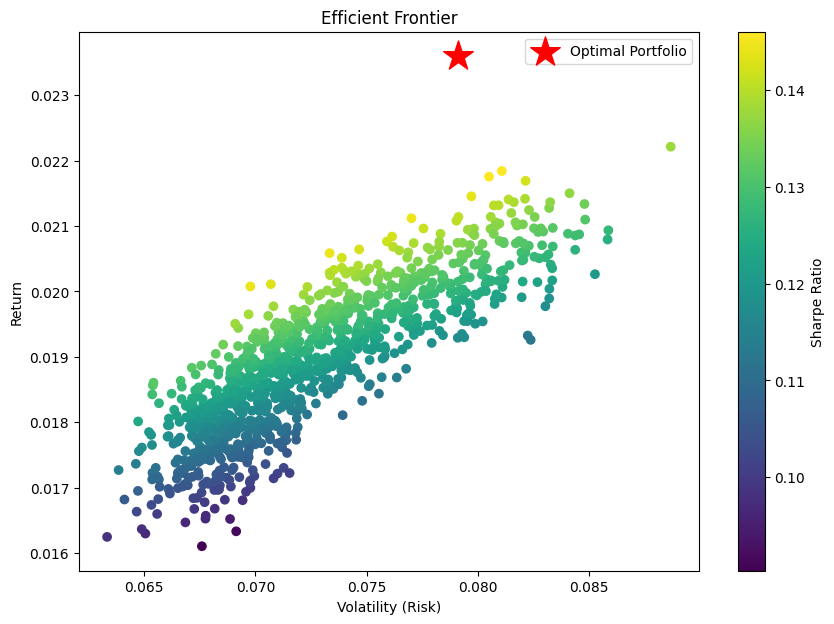

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load the dataset
file_path = 'Main Dataset.xlsx'
data = pd.read_excel(file_path, skiprows=2, index_col=0)

# Calculate monthly returns
returns = data.pct_change().dropna()

# Compute mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Define the objective function for the upper-level (Sharpe Ratio)
def sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe  # Negative because we're minimizing

# Lower-level Mean-Variance Portfolio problem with cardinality constraint
def mean_variance_portfolio(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Cardinality constraint function to limit number of assets
def cardinality_constraint(weights, max_assets):
    return max_assets - np.count_nonzero(weights)

# Evolutionary Algorithm (BASQP) for bi-level optimization with cardinality constraints
class BASQP:
    def __init__(self, mean_returns, cov_matrix, max_assets, population_size=100, max_iterations=100):
        self.mean_returns = mean_returns
        self.cov_matrix = cov_matrix
        self.max_assets = max_assets
        self.population_size = population_size
        self.max_iterations = max_iterations
    
    def initialize_population(self):
        """Initialize a population of portfolios (weights)"""
        population = np.random.rand(self.population_size, len(self.mean_returns))
        population /= population.sum(axis=1)[:, np.newaxis]  # Ensure weights sum to 1
        return population
    
    def evaluate_fitness(self, population):
        """Evaluate fitness (Sharpe Ratio) of each individual in the population"""
        fitness = np.array([sharpe_ratio(ind, self.mean_returns, self.cov_matrix) for ind in population])
        return fitness
    
    def apply_cardinality_constraint(self, population):
        """Apply cardinality constraint to population"""
        constrained_population = []
        for ind in population:
            if np.count_nonzero(ind) > self.max_assets:
                # Set small weights to zero until the constraint is met
                ind[np.argsort(ind)[:len(ind)-self.max_assets]] = 0
            constrained_population.append(ind / ind.sum())  # Re-normalize the weights
        return np.array(constrained_population)
    
    def crossover(self, parent1, parent2):
        """Perform crossover operation between two parent portfolios"""
        alpha = np.random.rand()
        child = alpha * parent1 + (1 - alpha) * parent2
        return child / np.sum(child)  # Re-normalize the weights
    
    def mutate(self, individual, mutation_rate=0.01):
        """Mutate an individual portfolio by adding random noise"""
        mutation = np.random.normal(0, mutation_rate, len(individual))
        individual += mutation
        individual[individual < 0] = 0  # Ensure no short-selling
        return individual / np.sum(individual)  # Re-normalize the weights
    
    def run(self):
        """Run the BASQP evolutionary algorithm"""
        population = self.initialize_population()
        best_individual = None
        best_fitness = np.inf
        
        for iteration in range(self.max_iterations):
            fitness = self.evaluate_fitness(population)
            if fitness.min() < best_fitness:
                best_fitness = fitness.min()
                best_individual = population[fitness.argmin()]
            
            # Apply crossover and mutation
            next_population = []
            for i in range(self.population_size):
                parent1, parent2 = population[np.random.choice(self.population_size, 2, replace=False)]
                child = self.crossover(parent1, parent2)
                child = self.mutate(child)
                next_population.append(child)
            
            # Apply cardinality constraint and re-evaluate
            population = self.apply_cardinality_constraint(np.array(next_population))
        
        return best_individual, best_fitness

# Set parameters
max_assets = 10
population_size = 200
max_iterations = 1000

# Run the evolutionary algorithm
basqp = BASQP(mean_returns, cov_matrix, max_assets, population_size, max_iterations)
optimal_weights, optimal_sharpe = basqp.run()

# Calculate the optimal portfolio performance
opt_return = np.dot(optimal_weights, mean_returns)
opt_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
opt_sharpe_ratio = (opt_return - 0.01) / opt_volatility

# Print the results
print(f"Optimal Portfolio Return: {opt_return}")
print(f"Optimal Portfolio Volatility: {opt_volatility}")
print(f"Optimal Portfolio Sharpe Ratio: {opt_sharpe_ratio}")

# Plot Efficient Frontier
def generate_random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate=0.01):
    results = np.zeros((3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe = (portfolio_return - risk_free_rate) / portfolio_volatility
        results[0, i] = portfolio_return
        results[1, i] = portfolio_volatility
        results[2, i] = sharpe
    return results

num_portfolios = 1000
results = generate_random_portfolios(num_portfolios, mean_returns, cov_matrix)

plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.scatter(opt_volatility, opt_return, marker='*', color='r', s=500, label='Optimal Portfolio')
plt.legend(labelspacing=0.8)
plt.show()
